In [2]:
import torch
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
num_workers = 0
batch_size=20

## transforms, and batch_sizes

transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomRotation(degrees=180),
                                #transforms.GaussianBlur(kernel_size=501),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


transform_test = transforms.Compose([transforms.Resize((256,256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


train_images = datasets.ImageFolder("/data/landmark_images/train", transform=transform)
test_images = datasets.ImageFolder("/data/landmark_images/test", transform=transform_test)


#create validation set
valid_size = 0.15
num_train = len(train_images)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)




# creating the loaders
train_loader = torch.utils.data.DataLoader(train_images, batch_size=batch_size,
    sampler=train_sampler,num_workers = 0,drop_last=True)
valid_loader = torch.utils.data.DataLoader(train_images, batch_size=batch_size, 
    sampler=valid_sampler,num_workers = 0,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_images, batch_size=batch_size,drop_last=True)





loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


In [4]:
classes = []
for label in train_images.class_to_idx:
    classes.append(label)

In [5]:
classes

['00.Haleakala_National_Park',
 '01.Mount_Rainier_National_Park',
 '02.Ljubljana_Castle',
 '03.Dead_Sea',
 '04.Wroclaws_Dwarves',
 '05.London_Olympic_Stadium',
 '06.Niagara_Falls',
 '07.Stonehenge',
 '08.Grand_Canyon',
 '09.Golden_Gate_Bridge',
 '10.Edinburgh_Castle',
 '11.Mount_Rushmore_National_Memorial',
 '12.Kantanagar_Temple',
 '13.Yellowstone_National_Park',
 '14.Terminal_Tower',
 '15.Central_Park',
 '16.Eiffel_Tower',
 '17.Changdeokgung',
 '18.Delicate_Arch',
 '19.Vienna_City_Hall',
 '20.Matterhorn',
 '21.Taj_Mahal',
 '22.Moscow_Raceway',
 '23.Externsteine',
 '24.Soreq_Cave',
 '25.Banff_National_Park',
 '26.Pont_du_Gard',
 '27.Seattle_Japanese_Garden',
 '28.Sydney_Harbour_Bridge',
 '29.Petronas_Towers',
 '30.Brooklyn_Bridge',
 '31.Washington_Monument',
 '32.Hanging_Temple',
 '33.Sydney_Opera_House',
 '34.Great_Barrier_Reef',
 '35.Monumento_a_la_Revolucion',
 '36.Badlands_National_Park',
 '37.Atomium',
 '38.Forth_Bridge',
 '39.Gateway_of_India',
 '40.Stockholm_City_Hall',
 '41.Ma

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: I decided to resize the images to 256x256 trying to find a compromize between computation efficency and effectiveness of the NN. I decided to apply some transformation to the training set to better simulate the different positioning of the cameras with shooting a pic.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 

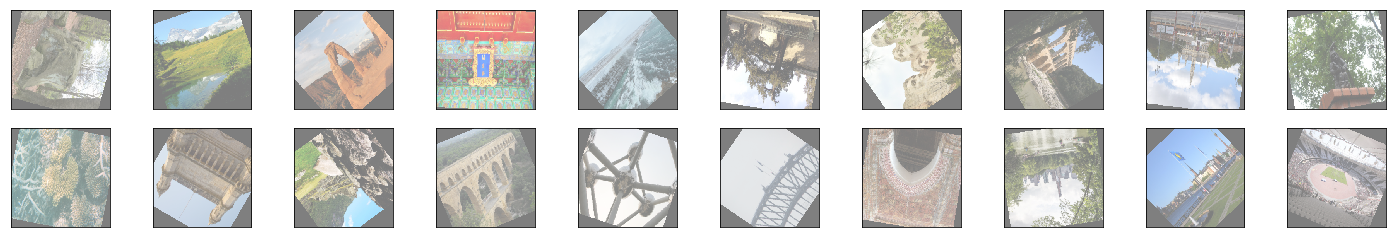

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

## visualize a batch of the train data loader

images, labels = iter(train_loader).next()



#denormalize the batch to visualize images

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

for image in images:
    invTrans(image)

images = images.numpy()



fig = plt.figure(figsize=(25, 4))


for idx in range(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    #ax.set_title(classes[labels[idx]])

### Initialize use_cuda variable

In [10]:
#  whether use or not the GPU
use_cuda = torch.cuda.is_available()

In [11]:
from torch.nn import CrossEntropyLoss
import torch.optim as optim 

criterion_scratch = CrossEntropyLoss()


def get_optimizer_scratch(model):
    
    return optim.SGD(model.parameters(),lr=0.01, momentum=0.9) 

In [12]:
import torch.nn as nn
import torch.nn.functional as F
output_classes = len(train_images.classes)

# define the CNN architecture
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        ## layers of a CNN
        self.conv1 = nn.Conv2d(3,16,kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16,32,kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32,64,kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64,64,kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64,128,kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        
        
        # fully connected layers
        self.fc1 = nn.Linear(128*8*8, 200)
        self.output = nn.Linear(200, output_classes)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        ## forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        
        
        x = x.view(-1,128*8*8)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.output(x)

        
        
        
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  I played a bit with the depth of the CNN and according to the suggestion of the mentor I increased the max number of filters from 64 to 128. Again the mentor suggested to limit the layers in the FCL that as I undersood limits overfitting

In [13]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    optimizer = get_optimizer_scratch(model)
        
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        # training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            optimizer.zero_grad()
            
            output = model.forward(data)
            
            loss = criterion(output,target)
            
            loss.backward()
            
            optimizer.step()
            
            train_loss += loss.item()*data.size(0)
            
            
        # evaluation mode
        model.eval()
        
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            output = model.forward(data)
            
            loss = criterion(output,target)
            
            valid_loss += loss.item()*data.size(0)

            
        train_loss = train_loss/len(loaders['train'])
        valid_loss = valid_loss/len(loaders['valid'])
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            ))

        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        
        
    return model

In [21]:
def normal_weight_init(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

In [11]:
model_scratch.apply(normal_weight_init)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=200, bias=True)
  (output): Linear(in_features=200, out_features=50, bias=True)
  (dropout): Dropout(p=0.25)
)

In [11]:
""""model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')"""

'"model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),\n                      criterion_scratch, use_cuda, \'ignore.pt\')'

In [22]:
num_epochs = 50


# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch_2.pt')

KeyboardInterrupt: 

In [14]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [11]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch_2.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.654037


Test Accuracy: 34% (433/1240)


In [15]:
loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

In [16]:
from torch.nn import CrossEntropyLoss
import torch.optim as optim 
## loss function
criterion_transfer = CrossEntropyLoss()


def get_optimizer_scratch(model):

    return optim.SGD(model.parameters(),lr=0.01, momentum=0.9) 

In [14]:
from torchvision import models

#load the pretained densenet
model_transfer = models.densenet121(pretrained=True)
if use_cuda:
    model_transfer = model_transfer.cuda()

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

# activate the grad for the last dense block
dense_block = model_transfer.features[9:]
for param in model_transfer.features[9:].parameters():
    param.requires_grad = True

model_transfer.classifier = nn.Sequential(nn.Dropout(0.25),
                           nn.Linear(4096,500),
                           nn.ReLU(),
                           nn.Linear(500,50)
                          )

if use_cuda:
    model_transfer.cuda()

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 78808063.52it/s]


__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  I decided to use a modern archinecture that as I understood tries to bypass the "vanishing gradients " by creating direct connections to among the the layers and particularly among these and the final dense layer to facilitate backpropagation. Lastly I appended a compact classifier to avoid overfitting.

In [17]:
criterion_transfer = CrossEntropyLoss()


def get_optimizer_scratch(model):
    
    return optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.9)

In [19]:
# train the model and save the best model parameters
num_epochs=10
trained_transfer = train(num_epochs, loaders_scratch, model_transfer, get_optimizer_scratch(model_transfer), 
                      criterion_scratch, use_cuda, 'model_transfer_dense.pt')

Epoch: 1 	Training Loss: 50.522361 	Validation Loss: 39.980745
Validation loss decreased (inf --> 39.980745).  Saving model ...
Epoch: 2 	Training Loss: 36.814223 	Validation Loss: 37.421340
Validation loss decreased (39.980745 --> 37.421340).  Saving model ...
Epoch: 3 	Training Loss: 32.581105 	Validation Loss: 36.923940
Validation loss decreased (37.421340 --> 36.923940).  Saving model ...
Epoch: 4 	Training Loss: 29.921121 	Validation Loss: 32.999983
Validation loss decreased (36.923940 --> 32.999983).  Saving model ...
Epoch: 5 	Training Loss: 27.396857 	Validation Loss: 31.846262
Validation loss decreased (32.999983 --> 31.846262).  Saving model ...
Epoch: 6 	Training Loss: 25.095866 	Validation Loss: 32.065981
Epoch: 7 	Training Loss: 23.640149 	Validation Loss: 33.507838
Epoch: 8 	Training Loss: 22.239521 	Validation Loss: 32.956404
Epoch: 9 	Training Loss: 22.279074 	Validation Loss: 31.162606
Validation loss decreased (31.846262 --> 31.162606).  Saving model ...
Epoch: 10 	Tr

In [62]:
model_transfer.load_state_dict(torch.load('model_transfer_dense.pt'))
#model_transfer.load_state_dict(torch.load('model_scratch_2.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.307388


Test Accuracy: 70% (869/1240)


In [18]:
import cv2
from PIL import Image
from torchvision import datasets,transforms, models
import torch
import matplotlib.pyplot as plt
import time



def predict_landmarks(img_path, k):
    
    transform_test = transforms.Compose([transforms.Resize((256,256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    
    image = Image.open(img_path).convert('RGB')
    plt.imshow(image)
    image = transform_test(image)[:3,:].unsqueeze(0).cuda()
    

    model_transfer = models.densenet121(pretrained=False)
    model_transfer.classifier = nn.Sequential(nn.Dropout(0.25),
                           nn.Linear(4096,500),
                           nn.ReLU(),
                           nn.Linear(500,50)
                          )
    model_transfer.eval()

    if use_cuda:
        model_transfer.cuda()

    #model_transfer.load_state_dict(torch.load('model_transfer_dense.pt'))
    model_transfer.load_state_dict(torch.load('model_transfer_dense.pt'))
    
    output = model_transfer(image)
    _, pred = output.topk(k, dim=1, sorted=True)
    preds = np.squeeze(pred.numpy()) if not use_cuda else np.squeeze(pred.cpu().numpy())
    
    if k==1:
        print("This fine-tuned DENSENET121 predicts that the landmark below is:"
              ,classes[preds])
        
    else:
        return ([classes[i] for i in preds])


/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


This fine-tuned DENSENET121 predicts that the landmark below is: 09.Golden_Gate_Bridge


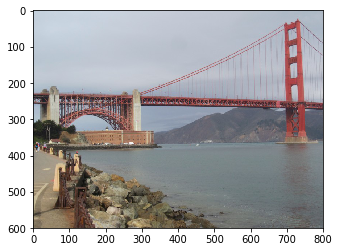

In [19]:
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 1)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


 Is this this location included in the following list? 
  
 ['37.Atomium', '15.Central_Park', '16.Eiffel_Tower']


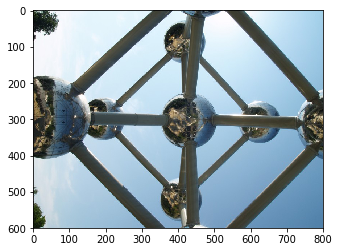

In [23]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    image = Image.open(img_path).convert('RGB')
    fig = plt.figure(figsize=(25, 4))
    
    print (" Is this this location included in the following list? \n ",
           "\n",
           predicted_landmarks)


suggest_locations('images/test/37.Atomium/5ecb74282baee5aa.jpg')

__Answer:__ (Three possible points for improvement) To be sincere I am enthusiast about the perfomance of the model since it classified all the four images correctly and had an overall accuracy of 70%. Since I retrained only the last dense-block, I am confident that by fine-tuning a larger portion of the network and by play

In [40]:
images = ["Dead_Sea","Monumento_a_la_Revolucion","niagara_falls","sidney_harbour_bridge"]

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


 Is this this location included in the following list? 
  
 ['03.Dead_Sea', '34.Great_Barrier_Reef', '36.Badlands_National_Park']
 Is this this location included in the following list? 
  
 ['35.Monumento_a_la_Revolucion', '39.Gateway_of_India', '45.Temple_of_Heaven']
 Is this this location included in the following list? 
  
 ['06.Niagara_Falls', '13.Yellowstone_National_Park', '43.Gullfoss_Falls']
 Is this this location included in the following list? 
  
 ['28.Sydney_Harbour_Bridge', '30.Brooklyn_Bridge', '33.Sydney_Opera_House']


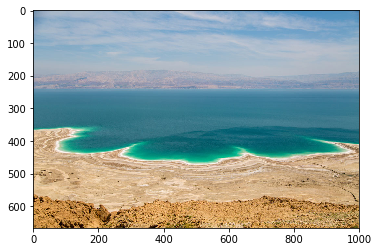

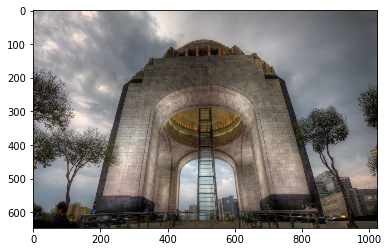

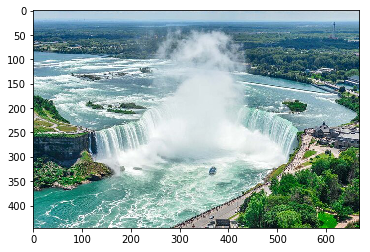

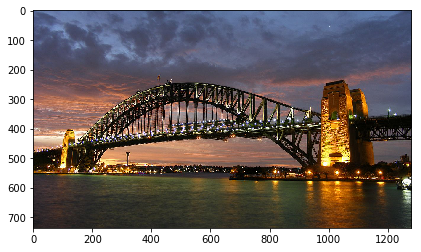

In [42]:
for image in images:
    suggest_locations("images/" + image+".jpg")